# IMU preintegration

An example for IMU Preintegration

## Data Preparation

* Download KITTI IMU sample data [2011_09_26.zip](https://github.com/pypose/IMU_preintegration/releases/download/Kitti/2011_09_26.zip).

* Extract the file to a folder [DATAROOT], so that it looks like:

        DATAROOT
            ├── 2011_09_26
                ├── 2011_09_26_drive_0001_sync
                ├── 2011_09_26_drive_0002_sync
                ├── 2011_09_26_drive_0005_sync
                .
                .
                .
                ├── 2011_09_26_drive_0018_sync
                ├── 2011_09_26_drive_0020_sync
                ├── 2011_09_26_drive_0022_sync
                ├── calib_cam_to_cam.txt
                ├── calib_imu_to_velo.txt
                └── calib_velo_to_cam.txt


In [1]:
!pip install pykitti
!python -m pip install -U matplotlib

In [2]:
import os
import torch
import pykitti
import argparse
import pypose as pp
from datetime import datetime
import matplotlib.pyplot as plt
import torch.utils.data as Data

In [3]:
class KITTI_IMU(Data.Dataset):
    def __init__(self, root, dataname, drive):
        super().__init__()
        self.data = pykitti.raw(root, dataname, drive)

    def __len__(self):
        return len(self.data.timestamps) - 1

    def __getitem__(self, i):
        dt = torch.tensor([datetime.timestamp(self.data.timestamps[i+1]) - datetime.timestamp(self.data.timestamps[i])])
        ang = torch.tensor([self.data.oxts[i].packet.wx, self.data.oxts[i].packet.wy, self.data.oxts[i].packet.wz])
        acc = torch.tensor([self.data.oxts[i].packet.ax, self.data.oxts[i].packet.ay, self.data.oxts[i].packet.az])
        vel = torch.tensor([self.data.oxts[i].packet.vf, self.data.oxts[i].packet.vl, self.data.oxts[i].packet.vu])
        rot = pp.euler2SO3([self.data.oxts[i].packet.roll, self.data.oxts[i].packet.pitch, self.data.oxts[i].packet.yaw])
        pos_gt = self.data.oxts[i].T_w_imu[0:3, 3]
        return dt, ang, acc, vel, rot, pos_gt

    def init_value(self):
        P = torch.tensor(self.data.oxts[0].T_w_imu[:3,3])
        R = pp.mat2SO3(torch.tensor(self.data.oxts[0].T_w_imu[:3,:3]))
        V = R @ torch.tensor([self.data.oxts[0].packet.vf, self.data.oxts[0].packet.vl, self.data.oxts[0].packet.vu])
        return P.unsqueeze(0), R.unsqueeze(0), V.unsqueeze(0)

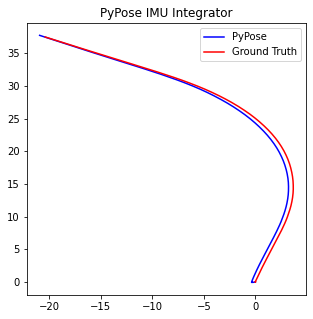

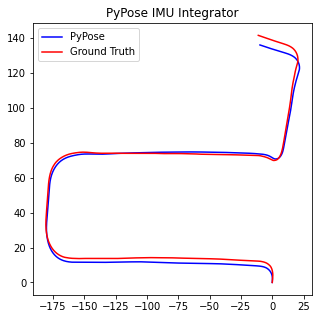

In [4]:
datadrive = ['0018', '0022']
dataroot, dataname = '.', '2011_09_26'
device = 'cpu' # or 'cuda:0'

torch.set_default_tensor_type(torch.DoubleTensor)

for drive in datadrive:
        dataset = KITTI_IMU(dataroot, dataname, drive)
        p, r, v = dataset.init_value()
        integrator = pp.IMUPreintegrator(p, r, v).to(device)
        loader = Data.DataLoader(dataset=dataset)
        poses, poses_gt = [p.to(device)], [p.to(device)]
        for idx, (dt, ang, acc, vel, rot, pos_gt) in enumerate(loader):
            dt,  ang = dt.to(device),  ang.to(device)
            acc, rot = acc.to(device), rot.to(device)
            pos_gt = pos_gt.to(device)
            integrator.update(dt, ang, acc, rot)
            pos, rot, vel = integrator()
            poses_gt.append(pos_gt)
            poses.append(pos)
        poses = torch.cat(poses).cpu().numpy()
        poses_gt = torch.cat(poses_gt).cpu().numpy()

        plt.figure(figsize=(5, 5))
        ax = plt.axes()
        ax.plot(poses[:,0], poses[:,1], 'b')
        ax.plot(poses_gt[:,0], poses_gt[:,1], 'r')
        plt.title("PyPose IMU Integrator")
        plt.legend(["PyPose", "Ground Truth"])
        plt.show()